In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [7]:
def sphere(individuo):
    resultado = 0
    for i in individuo:
        resultado += i ** 2
    return resultado
    
def rastrigin(individuo):
    resultado = 0
    for i in individuo:
        numero = 2*3.1415*i
        p = (numero/180)*math.pi
        resultado+= (i**2) - (10 * math.cos(p)) + 10    
    return resultado
    
def rosenbrock(individuo):
    resultado = 0
    for i in range(0,(len(individuo)-1)):
        resultado += 100*(individuo[i+1] - individuo[i]**2)**2 + (individuo[i] - 1)**2   
    return resultado

## Algoritmo ABC

In [2]:
class FonteAlimentacao:
    def __init__(self, dimensoes:int, limite_min: float, limite_max: float, fator_abandono:int, funcao_fitness):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max
        self.funcao_fitness = funcao_fitness

        self.posicao = np.random.uniform(limite_min, limite_max, dimensoes)
        self.fator_abandono = fator_abandono

        self.fitness = funcao_fitness(self.posicao)
        self.tentativas = 0
    
    def calcular_fitness(self):
        self.fitness = self.funcao_fitness(self.posicao) 

class Abelha:
    def __init__(self, dimensoes:int, limite_min: float, limite_max: float, funcao_fitness, fonte = None):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max
        self.funcao_fitness = funcao_fitness

        if fonte is not None:
            self.posicao = np.copy(fonte.posicao)
            self.fonte = fonte
            self.fitness = funcao_fitness(self.posicao)
        else:
            self.posicao = None
            self.fonte = None
            self.fitness = 0

    def calcular_posicao(self, fontes):
        indice_dimensao = random.randint(0, self.dimensoes - 1)
        indice_fonte = random.randint(0, len(fontes) - 1)
        while fontes[indice_fonte] == self.fonte:
            indice_fonte = random.randint(0, len(fontes) - 1)

        fator_aleatorio = random.uniform(-1, 1)
        nova_posicao = self.fonte.posicao[indice_dimensao] + fator_aleatorio * (
            self.fonte.posicao[indice_dimensao] - fontes[indice_fonte].posicao[indice_dimensao])
        
        nova_posicao = np.clip(nova_posicao, self.limite_min, self.limite_max)
        self.posicao[indice_dimensao] = nova_posicao

    def calcular_fitness(self):
        self.fitness = self.funcao_fitness(self.posicao) 

class AlgoritmoABC:
    def __init__(self, dimensoes:int, limite_min: float, limite_max: float, tamanho_populacao:int, fator_abandono:int, ciclos:int, funcao_fitness, funcao_selecao):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max

        self.tamanho_populacao = tamanho_populacao
        self.fator_abandono = fator_abandono
        self.ciclos = ciclos
        self.funcao_fitness = funcao_fitness
        self.funcao_selecao = funcao_selecao

        self.melhor_posicao = None
        self.melhor_fitness = float('inf')
        self.ciclo_best = 0

    def gerar_fontes(self):
        return [FonteAlimentacao(self.dimensoes, self.limite_min, self.limite_max, self.fator_abandono, self.funcao_fitness) 
                for _ in range(int(self.tamanho_populacao/2))]
    
    def gerar_abelhas_empregadas(self, fontes):
        return [Abelha(self.dimensoes, self.limite_min, self.limite_max, self.funcao_fitness, fonte=fonte) for fonte in fontes]
    
    def gerar_abelhas_observadoras(self):
        return [Abelha(dimensoes=self.dimensoes, limite_min=self.limite_min, limite_max=self.limite_max, funcao_fitness=self.funcao_fitness) 
                for _ in range(int(self.tamanho_populacao/2)) ]

    def executar_abelhas_empregadas(self, abelhas_empregadas, fontes):
        for abelha in abelhas_empregadas:
            abelha.calcular_posicao(fontes)
            abelha.calcular_fitness()
            fonte_abelha = abelha.fonte
            
            if abelha.fitness < fonte_abelha.fitness:
                fonte_abelha.posicao = np.copy(abelha.posicao)
                fonte_abelha.calcular_fitness()
                fonte_abelha.tentativas = 0
            else:
                fonte_abelha.tentativas += 1

    @staticmethod
    def selecionar_fonte_roleta(fontes):
        lista_fitness_minimo = [1 / (fonte.fitness) for fonte in fontes]
        total_fitness_minimo = sum(lista_fitness_minimo)
        probabilidades = [valor / total_fitness_minimo for valor in lista_fitness_minimo]

        return random.choices(fontes, weights=probabilidades, k=1)[0]
    
    @staticmethod
    def selecionar_fonte_torneio(fontes, tamanho_torneio=2):
        participantes_torneio = random.sample(fontes, tamanho_torneio)
        return min(participantes_torneio, key=lambda fonte: fonte.fitness)


    def executar_abelhas_observadoras(self, abelhas_observadoras, fontes):
        for abelha in abelhas_observadoras:
            fonte_selecionada = self.funcao_selecao(fontes)
            abelha.fonte = fonte_selecionada
            abelha.posicao = np.copy(fonte_selecionada.posicao)

            abelha.calcular_posicao(fontes)
            abelha.calcular_fitness()

            if abelha.fitness < fonte_selecionada.fitness:
                fonte_selecionada.posicao = np.copy(abelha.posicao)
                fonte_selecionada.calcular_fitness()
                fonte_selecionada.tentativas = 0
            else:
                fonte_selecionada.tentativas += 1

    def executar_abelhas_exploradoras(self, fontes):
        for fonte in fontes:
            if fonte.tentativas >= self.fator_abandono:
                fonte.posicao = np.random.uniform(self.limite_min, self.limite_max, self.dimensoes)
                fonte.calcular_fitness()
                fonte.tentativas = 0

    def plotar_grafico_convergencia(self, historico_fitness, funcao_fitness):
        x = [i for i in range(1, len(historico_fitness) + 1)]
        y = historico_fitness

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', linestyle='-', color='b', label='Melhor Fitness por Ciclo')
        plt.xlabel('Ciclo')
        plt.ylabel('Melhor Fitness')
        plt.title(f'Gráfico de Convergência do ABC - {funcao_fitness}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def executar(self):
        historico_fitness = []

        fontes = self.gerar_fontes()
        abelhas_empregadas = self.gerar_abelhas_empregadas(fontes=fontes)
        abelhas_observadores = self.gerar_abelhas_observadoras()

        for ciclo in range(self.ciclos):
            self.executar_abelhas_empregadas(abelhas_empregadas=abelhas_empregadas, fontes=fontes)
            self.executar_abelhas_observadoras(abelhas_observadoras=abelhas_observadores, fontes=fontes)
            self.executar_abelhas_exploradoras(fontes=fontes)

            for fonte in fontes:
                if fonte.fitness < self.melhor_fitness:
                    self.melhor_fitness = fonte.fitness
                    self.melhor_posicao = np.copy(fonte.posicao)
                    self.ciclo_best = ciclo
                    
            historico_fitness.append(self.melhor_fitness)
        
        return historico_fitness
    
    def exibir_melhor_fitness(self):
        print(f'Ciclo {self.ciclo_best} - Melhor Fitness: {self.melhor_fitness} - Melhor Posição: {self.melhor_posicao}')


### Execução do ABC - Sphere

Ciclo 1245 - Melhor Fitness: 1.0607719680551941 - Melhor Posição: [-0.10683283  0.32942668 -0.01808842  0.00582994 -0.01367125  0.2149372
 -0.13280716 -0.46622757  0.01139579 -0.29795682  0.13562387  0.31799933
  0.0272656   0.14633903 -0.61724248  0.04239041  0.11540653 -0.10790567
 -0.00299663 -0.14402858]


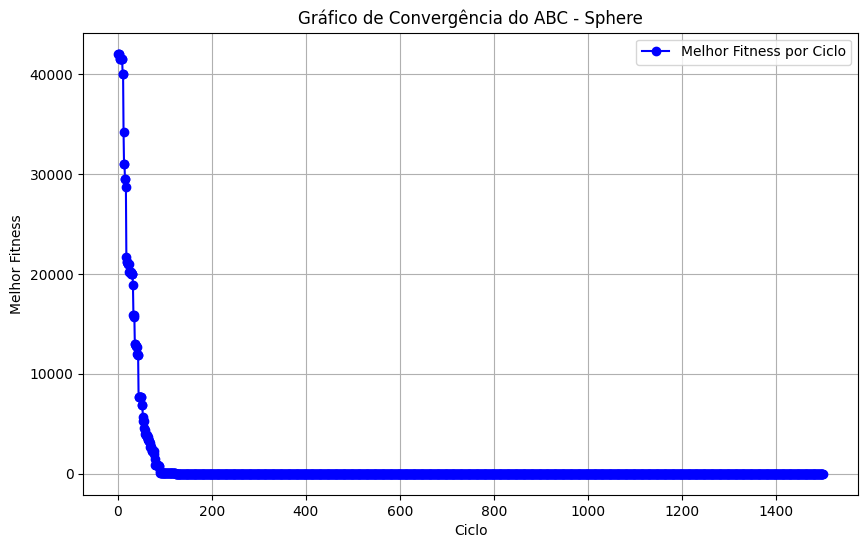

In [13]:
alg = AlgoritmoABC(dimensoes=20,
                   limite_min=-100.0,
                   limite_max=100.0,
                   tamanho_populacao=30,
                   fator_abandono=20,
                   ciclos=1500,
                   funcao_fitness=sphere,
                   funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)

historico_fitness = alg.executar()
alg.exibir_melhor_fitness()
alg.plotar_grafico_convergencia(historico_fitness=historico_fitness,funcao_fitness="Sphere")


### Execução do ABC - Rastrigin

Ciclo 1448 - Melhor Fitness: 0.11741306937124918 - Melhor Posição: [ 0.00775759 -0.02349928  0.08906892  0.2135683  -0.02246146 -0.01357081
  0.11745524 -0.0607866  -0.00315674  0.02340065  0.14204141  0.02074922
 -0.01021157 -0.09305447  0.06436376  0.01357939  0.05241295  0.02762159
 -0.01145776  0.0228446 ]


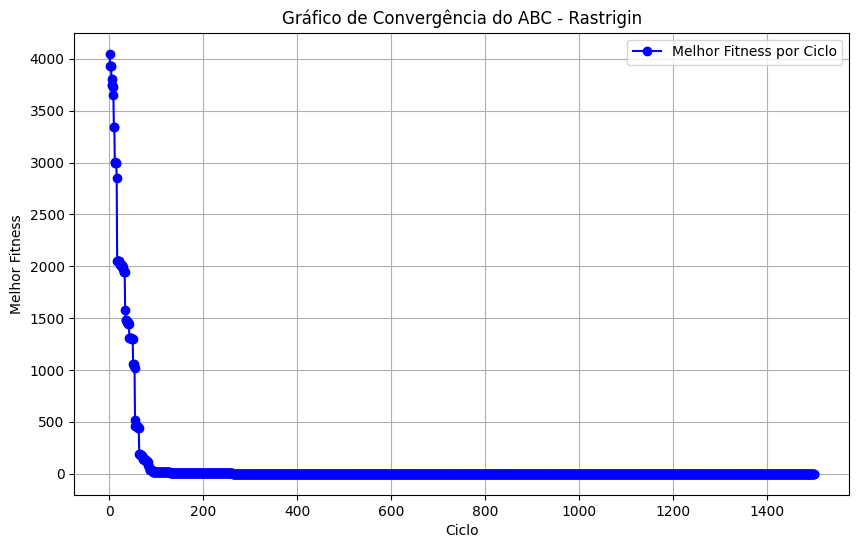

In [14]:
alg = AlgoritmoABC(dimensoes=20,
                   limite_min=-30.0,
                   limite_max=30.0,
                   tamanho_populacao=30,
                   fator_abandono=20,
                   ciclos=1500,
                   funcao_fitness=rastrigin,
                   funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)

historico_fitness = alg.executar()
alg.exibir_melhor_fitness()
alg.plotar_grafico_convergencia(historico_fitness=historico_fitness,funcao_fitness="Rastrigin")


### Execução do ABC - Rosenbrock

Ciclo 1100 - Melhor Fitness: 54.90294606865673 - Melhor Posição: [1.16907683 0.98943136 1.00480842 0.95420579 0.93150378 0.93127057
 0.92925997 1.06958504 1.09029624 1.03359009 0.93234533 0.92389727
 0.89295978 0.86617207 1.10475096 0.9900689  1.14713941 1.4506952
 2.29181663 5.12      ]


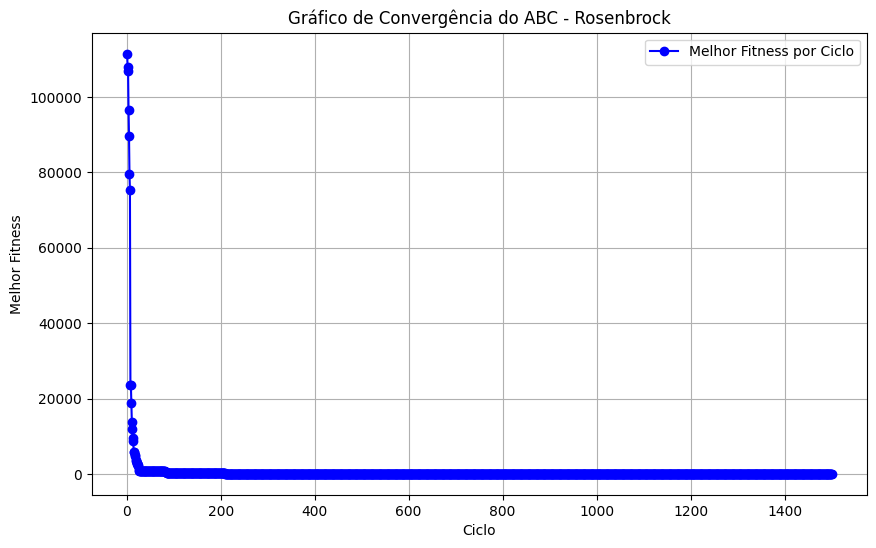

In [28]:
alg = AlgoritmoABC(dimensoes=20,
                   limite_min=-5.12,
                   limite_max=5.12,
                   tamanho_populacao=30,
                   fator_abandono=15,
                   ciclos=1500,
                   funcao_fitness=rosenbrock,
                   funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)

historico_fitness = alg.executar()
alg.exibir_melhor_fitness()
alg.plotar_grafico_convergencia(historico_fitness=historico_fitness,funcao_fitness="Rosenbrock")


### Gráfico de convergência ABC - Sphere

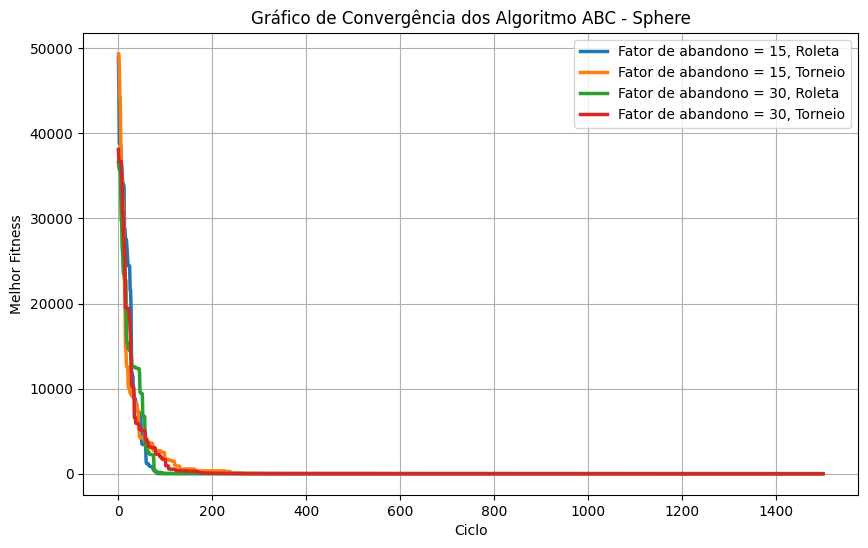

In [16]:
alg = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=30, fator_abandono=15,
                   ciclos=1500, funcao_fitness=sphere, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
best_fitness1 = alg.executar()


alg2 = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=30, fator_abandono=15,
                   ciclos=1500, funcao_fitness=sphere, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
best_fitness2 = alg2.executar()


alg3 = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=30, fator_abandono=30,
                   ciclos=1500, funcao_fitness=sphere, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
best_fitness3 = alg3.executar()


alg4 = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=30, fator_abandono=30,
                   ciclos=1500, funcao_fitness=sphere, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
best_fitness4 = alg4.executar()


colors = plt.get_cmap("tab10")
plt.figure(figsize=(10, 6))
plt.plot(best_fitness1, label='Fator de abandono = 15, Roleta', color=colors(0), linewidth=2.5)
plt.plot(best_fitness2, label='Fator de abandono = 15, Torneio', color=colors(1), linewidth=2.5)
plt.plot(best_fitness3, label='Fator de abandono = 30, Roleta', color=colors(2), linewidth=2.5)
plt.plot(best_fitness4, label='Fator de abandono = 30, Torneio', color=colors(3), linewidth=2.5)

plt.xlabel('Ciclo')
plt.ylabel('Melhor Fitness')
plt.title('Gráfico de Convergência dos Algoritmo ABC - Sphere')
plt.legend()
plt.grid(True)
plt.show()

### Gráfico de convergência ABC - Rastrigin

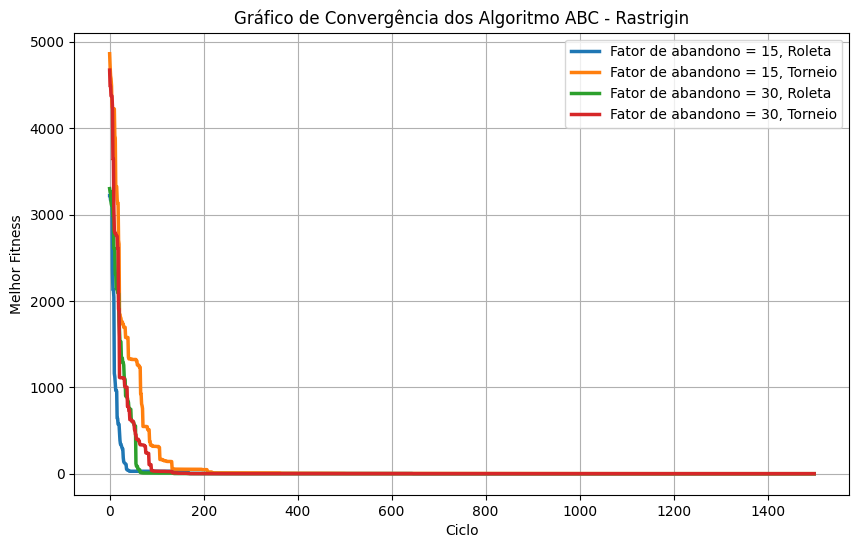

In [18]:
alg = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=30, fator_abandono=15,
                   ciclos=1500, funcao_fitness=rastrigin, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
best_fitness1 = alg.executar()


alg2 = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=30, fator_abandono=15,
                   ciclos=1500, funcao_fitness=rastrigin, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
best_fitness2 = alg2.executar()


alg3 = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=30, fator_abandono=30,
                   ciclos=1500, funcao_fitness=rastrigin, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
best_fitness3 = alg3.executar()


alg4 = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=30, fator_abandono=30,
                   ciclos=1500, funcao_fitness=rastrigin, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
best_fitness4 = alg4.executar()


colors = plt.get_cmap("tab10")
plt.figure(figsize=(10, 6))
plt.plot(best_fitness1, label='Fator de abandono = 15, Roleta', color=colors(0), linewidth=2.5)
plt.plot(best_fitness2, label='Fator de abandono = 15, Torneio', color=colors(1), linewidth=2.5)
plt.plot(best_fitness3, label='Fator de abandono = 30, Roleta', color=colors(2), linewidth=2.5)
plt.plot(best_fitness4, label='Fator de abandono = 30, Torneio', color=colors(3), linewidth=2.5)

plt.xlabel('Ciclo')
plt.ylabel('Melhor Fitness')
plt.title('Gráfico de Convergência dos Algoritmo ABC - Rastrigin')
plt.legend()
plt.grid(True)
plt.show()

### Gráfico de convergência ABC - Rosenbrock

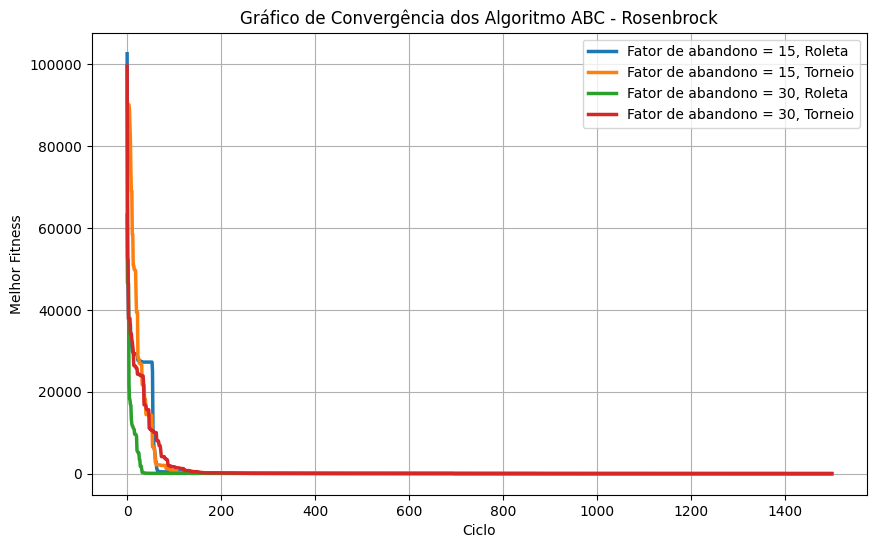

In [27]:
alg = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=30, fator_abandono=15,
                   ciclos=1500, funcao_fitness=rosenbrock, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
best_fitness1 = alg.executar()


alg2 = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=30, fator_abandono=15,
                   ciclos=1500, funcao_fitness=rosenbrock, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
best_fitness2 = alg2.executar()


alg3 = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=30, fator_abandono=30,
                   ciclos=1500, funcao_fitness=rosenbrock, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
best_fitness3 = alg3.executar()


alg4 = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=30, fator_abandono=30,
                   ciclos=1500, funcao_fitness=rosenbrock, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
best_fitness4 = alg4.executar()


colors = plt.get_cmap("tab10")
plt.figure(figsize=(10, 6))
plt.plot(best_fitness1, label='Fator de abandono = 15, Roleta', color=colors(0), linewidth=2.5)
plt.plot(best_fitness2, label='Fator de abandono = 15, Torneio', color=colors(1), linewidth=2.5)
plt.plot(best_fitness3, label='Fator de abandono = 30, Roleta', color=colors(2), linewidth=2.5)
plt.plot(best_fitness4, label='Fator de abandono = 30, Torneio', color=colors(3), linewidth=2.5)

plt.xlabel('Ciclo')
plt.ylabel('Melhor Fitness')
plt.title('Gráfico de Convergência dos Algoritmo ABC - Rosenbrock')
plt.legend()
plt.grid(True)
plt.show()

### Boxplot com Função fitness: Sphere

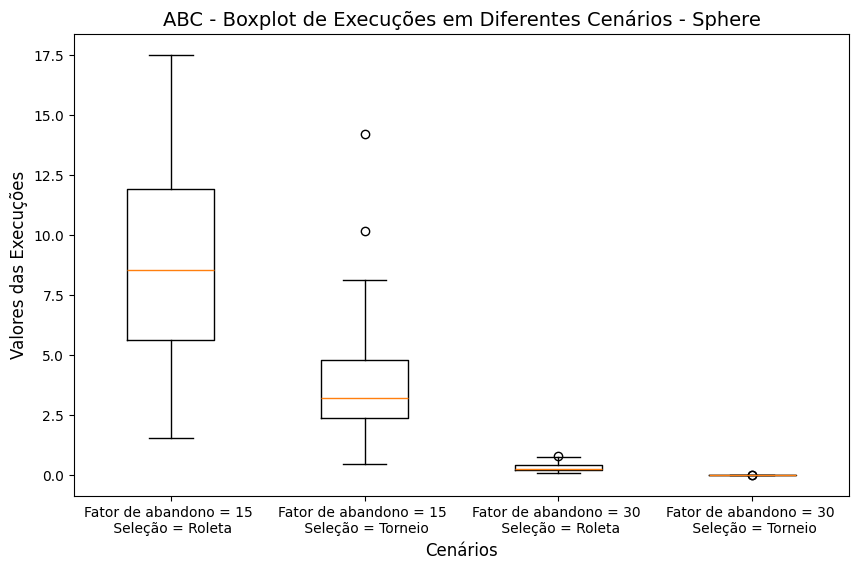

In [22]:
cenario_1 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=30,fator_abandono=15   , 
                       ciclos=1500, funcao_fitness=sphere, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
    alg.executar()
    cenario_1.append(alg.melhor_fitness)

cenario_2 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=30,fator_abandono=15, 
                       ciclos=1500, funcao_fitness=sphere, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
    alg.executar()
    cenario_2.append(alg.melhor_fitness)

cenario_3 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=30,fator_abandono=30, 
                       ciclos=1500, funcao_fitness=sphere, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
    alg.executar()
    cenario_3.append(alg.melhor_fitness)

cenario_4 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=30,fator_abandono=30, 
                       ciclos=1500, funcao_fitness=sphere, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
    alg.executar()
    cenario_4.append(alg.melhor_fitness)

dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Fator de abandono = 15 \n Seleção = Roleta', 'Fator de abandono = 15 \n Seleção = Torneio', 'Fator de abandono = 30 \n Seleção = Roleta', 'Fator de abandono = 30 \n Seleção = Torneio'])

plt.title('ABC - Boxplot de Execuções em Diferentes Cenários - Sphere', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()

### Boxplot com Função fitness: Rastrigin

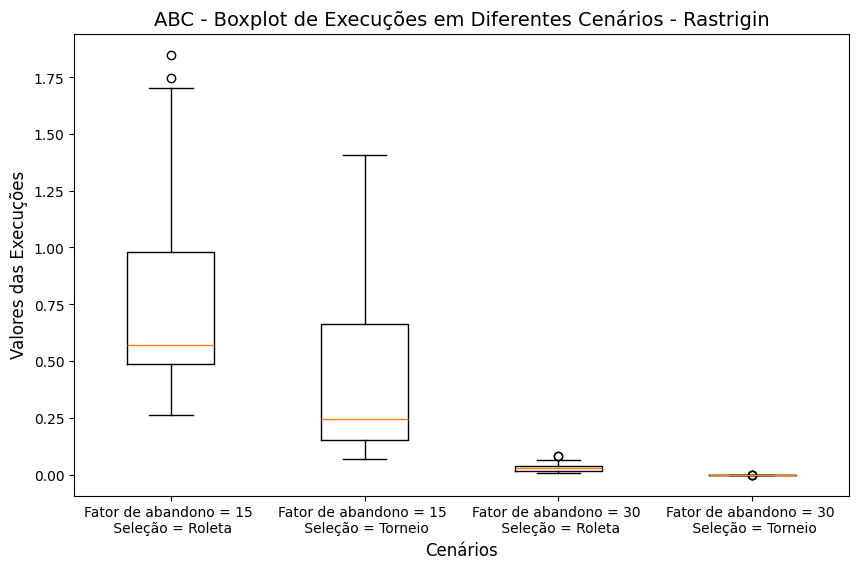

In [23]:
cenario_1 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=30,fator_abandono=15   , 
                       ciclos=1500, funcao_fitness=rastrigin, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
    alg.executar()
    cenario_1.append(alg.melhor_fitness)

cenario_2 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=30,fator_abandono=15, 
                       ciclos=1500, funcao_fitness=rastrigin, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
    alg.executar()
    cenario_2.append(alg.melhor_fitness)

cenario_3 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=30,fator_abandono=30, 
                       ciclos=1500, funcao_fitness=rastrigin, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
    alg.executar()
    cenario_3.append(alg.melhor_fitness)

cenario_4 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=30,fator_abandono=30, 
                       ciclos=1500, funcao_fitness=rastrigin, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
    alg.executar()
    cenario_4.append(alg.melhor_fitness)

dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Fator de abandono = 15 \n Seleção = Roleta', 'Fator de abandono = 15 \n Seleção = Torneio', 'Fator de abandono = 30 \n Seleção = Roleta', 'Fator de abandono = 30 \n Seleção = Torneio'])

plt.title('ABC - Boxplot de Execuções em Diferentes Cenários - Rastrigin', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()

### Boxplot com Função fitness: Rosenbrock

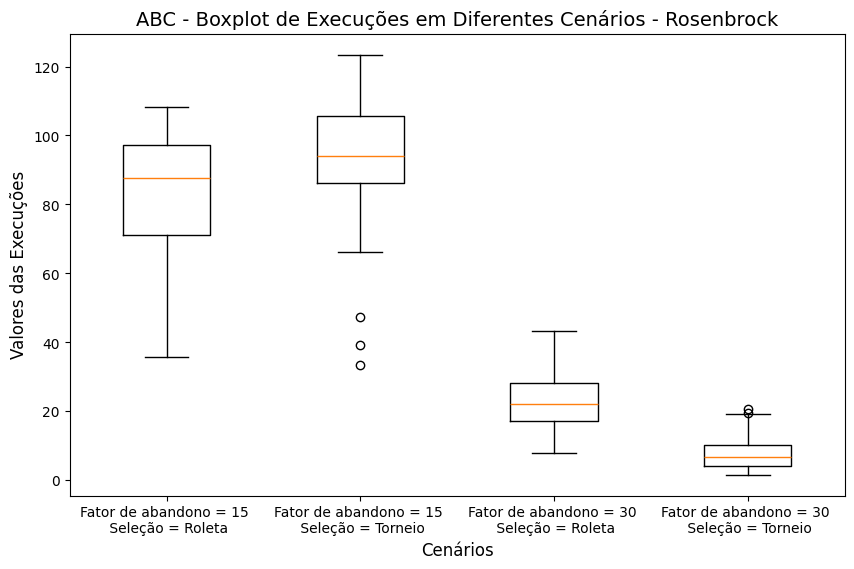

In [26]:
cenario_1 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=30,fator_abandono=15   , 
                       ciclos=1500, funcao_fitness=rosenbrock, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
    alg.executar()
    cenario_1.append(alg.melhor_fitness)

cenario_2 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=30,fator_abandono=15, 
                       ciclos=1500, funcao_fitness=rosenbrock, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
    alg.executar()
    cenario_2.append(alg.melhor_fitness)

cenario_3 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=30,fator_abandono=30, 
                       ciclos=1500, funcao_fitness=rosenbrock, funcao_selecao= AlgoritmoABC.selecionar_fonte_roleta)
    alg.executar()
    cenario_3.append(alg.melhor_fitness)

cenario_4 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=30,fator_abandono=30, 
                       ciclos=1500, funcao_fitness=rosenbrock, funcao_selecao= AlgoritmoABC.selecionar_fonte_torneio)
    alg.executar()
    cenario_4.append(alg.melhor_fitness)

dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Fator de abandono = 15 \n Seleção = Roleta', 'Fator de abandono = 15 \n Seleção = Torneio', 'Fator de abandono = 30 \n Seleção = Roleta', 'Fator de abandono = 30 \n Seleção = Torneio'])

plt.title('ABC - Boxplot de Execuções em Diferentes Cenários - Rosenbrock', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()